In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357277 sha256=9be94cddfb43ad839ffd66677e3c292523b3e4b28e359969bbac2bb7c0e85e5c
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import SVD, KNNBasic, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with the added 'Course' column
df = pd.read_csv("/content/faculty_recommendation_dataset_with_course.csv")

# Manually add a 'Course' column (assuming courses are distributed)
# Replace or update this with your actual data if courses are defined.
df["Course"] = ["Course_" + str(i % 5 + 1) for i in range(len(df))]

# Display dataset summary
print("Dataset Info:")
print(df.info())
print("\nDataset Preview:")
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Student ID              500 non-null    object
 1   Student Name            500 non-null    object
 2   Teaching Preference     500 non-null    object
 3   Faculty Name            500 non-null    object
 4   Faculty Teaching Style  500 non-null    object
 5   Rating                  500 non-null    int64 
 6   Course                  500 non-null    object
dtypes: int64(1), object(6)
memory usage: 27.5+ KB
None

Dataset Preview:
  Student ID Student Name Teaching Preference Faculty Name  \
0        S01    Student_1           Practical    Faculty_1   
1        S01    Student_1           Practical    Faculty_2   
2        S01    Student_1           Practical    Faculty_3   
3        S01    Student_1           Practical    Faculty_4   
4        S01    Student_1     

**Visualize Data Insights**

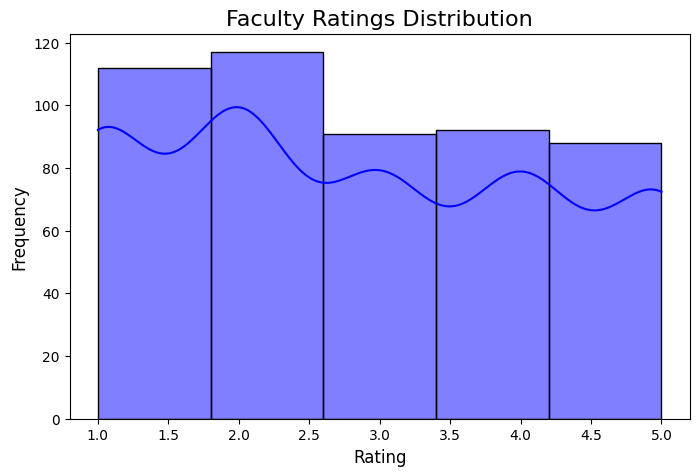

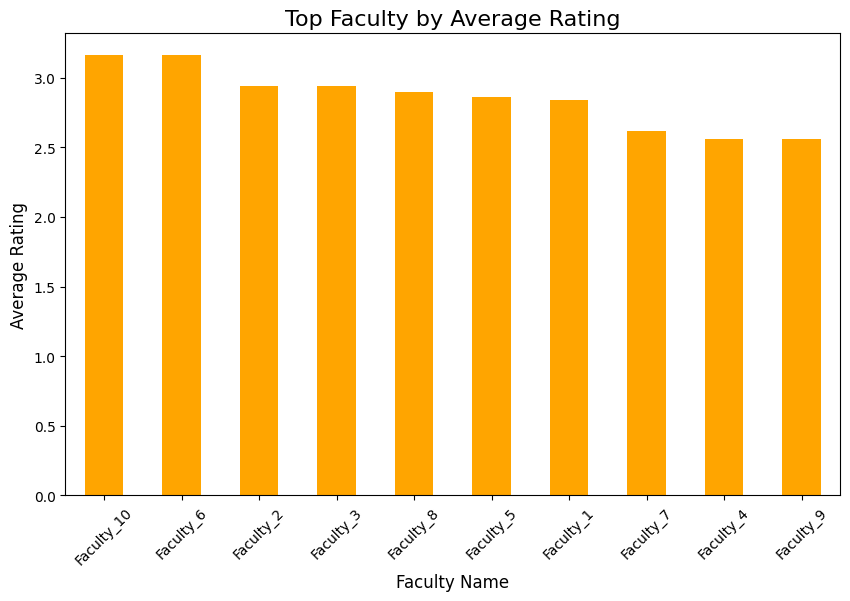

<ipython-input-5-153b2421c59f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Course", palette="muted")


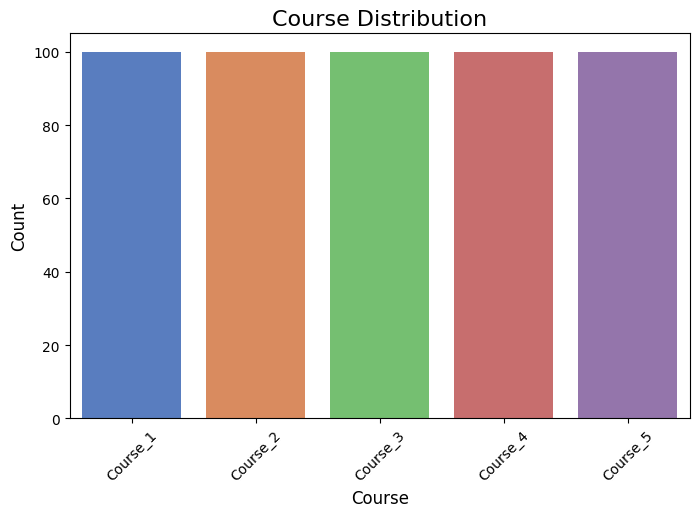

In [ ]:
# Plot: Faculty Ratings Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Rating"], bins=5, kde=True, color='blue')
plt.title("Faculty Ratings Distribution", fontsize=16)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

# Plot: Top Faculty by Average Rating
avg_ratings = df.groupby("Faculty Name")["Rating"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
avg_ratings.head(10).plot(kind='bar', color='orange')
plt.title("Top Faculty by Average Rating", fontsize=16)
plt.xlabel("Faculty Name", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Plot: Distribution of Courses
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Course", palette="muted")
plt.title("Course Distribution", fontsize=16)
plt.xlabel("Course", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()


**Collaborative Filtering**

In [ ]:
# Prepare data for Collaborative Filtering
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["Student ID", "Faculty Name", "Rating"]], reader)

# Train-Test Split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# SVD Model
svd = SVD()
svd.fit(trainset)
predictions = svd.test(testset)
print("\nCollaborative Filtering (SVD) RMSE:")
rmse(predictions)

# KNN Model for Collaborative Filtering
sim_options = {'name': 'cosine', 'user_based': False}  # Use item-based similarity
knn = KNNBasic(sim_options=sim_options)
knn.fit(trainset)
knn_predictions = knn.test(testset)
print("\nCollaborative Filtering (KNN) RMSE:")
rmse(knn_predictions)



Collaborative Filtering (SVD) RMSE:
RMSE: 1.4384
Computing the cosine similarity matrix...
Done computing similarity matrix.

Collaborative Filtering (KNN) RMSE:
RMSE: 1.5049


1.5049462597048306

**Content-Based Recommendation**

In [ ]:
# Content-Based Recommendation
vectorizer = TfidfVectorizer()
df["Teaching Features"] = df["Faculty Teaching Style"] + " " + df["Course"]
faculty_features = vectorizer.fit_transform(df["Teaching Features"])

def content_based_recommendation(student_id, course, top_n=3):
    # Get the student's teaching preference
    student_pref = df[(df["Student ID"] == student_id) & (df["Course"] == course)]
    if student_pref.empty:
        print(f"No data available for Student ID: {student_id} in {course}.")
        return None

    student_pref_vec = vectorizer.transform(student_pref["Teaching Preference"].unique())

    # Compute similarity
    similarity = cosine_similarity(student_pref_vec, faculty_features).flatten()

    # Top N recommendations
    faculty_indices = np.argsort(similarity)[-top_n:][::-1]
    recommendations = df.iloc[faculty_indices][["Faculty Name", "Faculty Teaching Style", "Course"]]
    return recommendations.drop_duplicates()

# Test Content-Based Recommendation
student_id = "S03"
course = "Course_1"
print(f"\nContent-Based Recommendations for {student_id} in {course}:")
print(content_based_recommendation(student_id, course))



Content-Based Recommendations for S03 in Course_1:
    Faculty Name Faculty Teaching Style    Course
499   Faculty_10            Theoretical  Course_5


**Hybrid Recommendation**


Hybrid Recommendations for S03 in Course_1:
  Faculty Name Faculty Teaching Style    Course  Content_Score  CF_Score  \
0   Faculty_10            Theoretical  Course_5            1.0  2.805891   
1    Faculty_4            Theoretical  Course_4            0.0  2.424628   

   Hybrid_Score  
0      1.902945  
1      1.212314  


<ipython-input-9-28c353ff30b9>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Faculty Name', y='Hybrid_Score', data=hybrid_recs, palette='viridis')


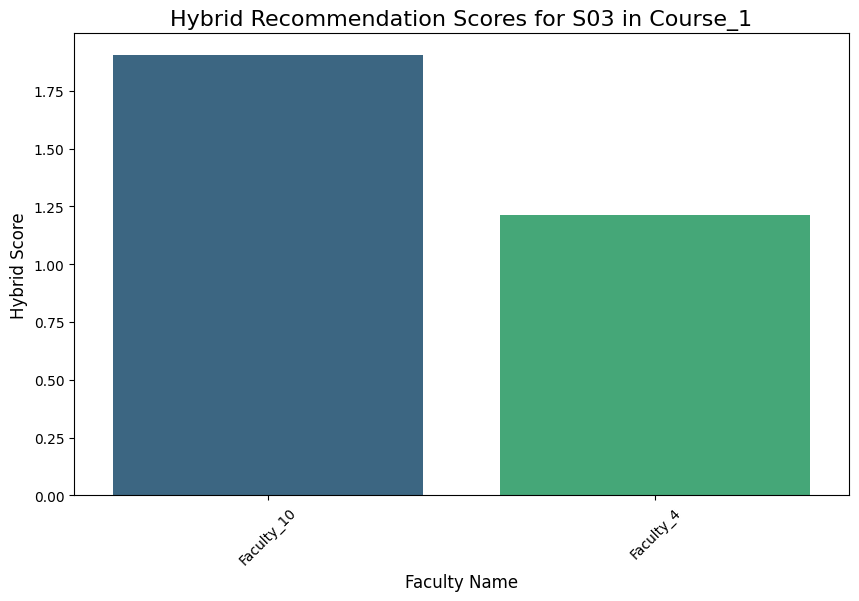

In [ ]:
# Hybrid Recommendation
def hybrid_recommendation(student_id, course, faculty_names, top_n=5):
    content_recs = content_based_recommendation(student_id, course, top_n=10)
    if content_recs is None:
        return None

    content_recs["Content_Score"] = np.linspace(1, 0, len(content_recs))  # Rank-based score

    # Collaborative filtering predictions
    cf_scores = []
    for faculty in faculty_names:
        pred = svd.predict(student_id, faculty)
        cf_scores.append((faculty, pred.est))

    cf_df = pd.DataFrame(cf_scores, columns=["Faculty Name", "CF_Score"])

    # Merge scores
    hybrid_df = content_recs.merge(cf_df, on="Faculty Name", how="inner")
    hybrid_df["Hybrid_Score"] = 0.5 * hybrid_df["Content_Score"] + 0.5 * hybrid_df["CF_Score"]

    # Sort by hybrid score
    return hybrid_df.sort_values(by="Hybrid_Score", ascending=False).head(top_n)

# Generate Hybrid Recommendations
faculty_names = df["Faculty Name"].unique()
print(f"\nHybrid Recommendations for {student_id} in {course}:")
hybrid_recs = hybrid_recommendation(student_id, course, faculty_names, top_n=5)
print(hybrid_recs)

# Plot: Hybrid Recommendation Scores
if hybrid_recs is not None:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Faculty Name', y='Hybrid_Score', data=hybrid_recs, palette='viridis')
    plt.title(f"Hybrid Recommendation Scores for {student_id} in {course}", fontsize=16)
    plt.xlabel("Faculty Name", fontsize=12)
    plt.ylabel("Hybrid Score", fontsize=12)
    plt.xticks(rotation=45)
    plt.show()
